In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, fsolve
from tqdm import tqdm

plt.style.use('classic')
np.random.seed(0)

**Primal**

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_2} &= 1\\
u\vert_{\Gamma_3}&=0
\end{align*}$$

**Dual**

$$\begin{align*}
\nabla \cdot (A^* \nabla p) &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_2} &= 0\\
p\vert_{\Gamma_3}&=\rho
\end{align*}$$

In [2]:
class finite_differences():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(1,0),edge_order=2))
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=2))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

**Design Matrix**
$$\begin{align*}
\lambda_- &= \bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-1}\\[2ex]
\lambda_+ &= \alpha\theta+\beta(1-\theta)
\end{align*}$$

In [3]:
def genLam(theta,shape,alpha=1,beta=.5):
    lamMinus=np.ma.power(theta/alpha+(np.ones(shape)-theta)/beta,-1)
    lamPlus=alpha*theta+beta*(np.ones(shape)-theta)
    return lamMinus,lamPlus

$$\begin{align*}
A^* &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \lambda_+ & 0\\ 0 & \lambda_-\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\[2ex]
&=\begin{pmatrix}
\lambda_+\cos^2(\phi)+\lambda_-\sin^2(\phi) & (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi)
\\ (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi) & \lambda_+\sin^2(\phi)+\lambda_-\cos^2(\phi)
\end{pmatrix}\end{align*}$$

In [4]:
def genA(theta,phi,shape,alpha=1,beta=.1):
    A = np.zeros([2,2]+shape)
    lamPlus,lamMinus=genLam(theta,shape,alpha,beta)
    #BLOCK A
    for i in range(shape[0]):
        for j in range(shape[1]):
            A1=lamPlus[i,j]*np.cos(phi[i,j])**2+lamMinus[i,j]*np.sin(phi[i,j])**2
            A2=(lamPlus[i,j]+lamMinus[i,j])*np.sin(phi[i,j])*np.cos(phi[i,j])
            A3=lamPlus[i,j]*np.sin(phi[i,j])**2+lamMinus[i,j]*np.cos(phi[i,j])**2
            A[...,i,j]=np.array([[A1,A2],[A2,A3]])
    return A

$$\begin{align*}
\frac{\partial\lambda_-}{\partial\theta} &= -\bigg(\frac{1}{\alpha} - \frac{1}{\beta}\bigg)\bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-2}\\
\frac{\partial\lambda_+}{\partial\theta} &= \alpha-\beta\\
\end{align*}$$

In [5]:
def lam_theta(theta,shape,alpha=1,beta=.5):
    n,m=shape
    lamMinus_theta =-np.ma.power((1/alpha-1/beta)*(theta/alpha+(np.ones(n,m)-theta)/beta),-2)
    lamPlus_theta=alpha*theta+beta*(np.ones(n,m)-theta)
    return lamPlus_theta,lamMinus_theta

$$\begin{align*}
\frac{\partial A}{\partial\theta} &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \frac{\partial\lambda_+}{\partial\theta} & 0\\ 0 & \frac{\partial\lambda_-}{\partial\theta}\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
\end{align*}$$

In [6]:
def A_theta(thetaK,phiK,alpha=1,beta=.1):
    lamMinus_theta=-(1/alpha-1/beta)*((thetaK/alpha+(1-thetaK)/beta)**(-2))
    lamPlus_theta=alpha-beta

    A1=lamPlus_theta*np.cos(phiK)**2+lamMinus_theta*np.sin(phiK)**2
    A2=(-lamPlus_theta+lamMinus_theta)*np.sin(phiK)*np.cos(phiK)
    A3=lamPlus_theta*np.sin(phiK)**2+lamMinus_theta*np.cos(phiK)**2
  
    A_theta=np.array([[A1,A2],[A2,A3]])
    return A_theta

$$\begin{align*}
\frac{\partial A}{\partial\phi} &= \begin{pmatrix} (-\lambda_++\lambda_-)(2\cos(\phi)\sin(\phi)) & (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi))
\\ (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi)) & (\lambda_+-\lambda_-)(2\cos(\phi)\sin(\phi)) \end{pmatrix}\end{align*}$$

In [7]:
def A_phi(thetaK,phiK,alpha=1,beta=.1):
    lamPlus=np.ma.power(thetaK/alpha+(1-thetaK)/beta,-1)
    lamMinus=alpha*thetaK-beta*(1-thetaK)

    A1=(-lamPlus+lamMinus)*2*np.sin(phiK)*np.cos(phiK)
    A2=(-lamPlus+lamMinus)*(np.cos(phiK)**2-np.sin(phiK)**2)
    A3=(lamPlus-lamMinus)*2*np.sin(phiK)*np.cos(phiK)

    A_phi=np.array([[A1,A2],[A2,A3]])
    return A_phi

**Design Method**

* Solve $u$

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_2} &= 1\\
u\vert_{\Gamma_3}&=0
\end{align*}$$

* Solve $p$

$$\begin{align*}
\nabla \cdot (A^* \nabla p) &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_2} &= 0\\
p\vert_{\Gamma_3}&=\rho
\end{align*}$$


* Update $\theta$
$$\begin{align*}
\theta_{k+1} = \max \bigg( 0,\min \bigg(1,\theta_k-t_k\bigg(\ell_k+\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\bigg) \bigg)\bigg)\end{align*}$$

* Update $\phi$
$$\begin{align*}
\phi_{k+1} = \phi_k-t_k\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\end{align*}$$

In [8]:
class heatLens():
    def __init__(self,x,y,options={}):
        #DOMAIN
        self.m=len(x)
        self.n=len(y)
        self.dx = 1/(m+1)
        self.dy = 1/(n+1)
        self.domain_len = self.m*self.n
        self.domain_shape = (self.m,self.n)
        self.xx, self.yy = np.meshgrid(x,y)
        self.zeros = np.zeros(self.domain_shape)
        self.ones = np.ones(self.domain_shape)
        self.interior = np.ones(self.domain_shape);
        self.interior[0,:]=np.zeros(m);self.interior[-1,:]=np.zeros(m);
        self.interior[:,0]=np.zeros(n);self.interior[:,-1]=np.zeros(n)
        #OPTIONS
        self.options=options
        self.check_options()
        #BOUNDARY DATA
        self.neumann_bcs = self.options['neumann_bcs']
        self.dirichlet_bcs = self.options['dirichlet_bcs']
        self.neumann_loc = self.options['neumann_loc']
        self.dirichlet_loc = self.options['dirichlet_loc']
        #INITIALIZE
        self.u=np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.p=np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.theta=np.ones(self.domain_shape)#np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.phi=np.zeros(self.domain_shape)#np.pi*np.random.rand(self.domain_len).reshape(self.domain_shape)#
        self.lv=self.options['lv']
        self.vol=self.options['volume']
        #DIFFERENCES
        self.fd = finite_differences(m,n,dx,dy)
        self.contract = lambda a,b,c : np.einsum('ijk,ijk->jk',b,
                        np.einsum('ijkl,jkl->ikl',a,c))

    def iterate(self,k):
        pbar = tqdm(range(k))
        for _ in pbar:
            self._iter()
            pbar.set_description(desc=str(self.lv))

    def _iter(self):
        #INITIALIZE
        alpha=self.options['alpha']
        beta=self.options['beta']
        tk=self.options['tk']
        #COEFFICIENTS
        A=genA(self.theta,self.phi,[self.m,self.n],alpha=alpha,beta=beta)
        self.fd.A = A
        #PRIMAL SOLUTION VIA RESIDUAL
        primal = lambda v : (self.interior*(-self.fd.divAgrad(v))
                                +self.dirichlet_loc*(v.reshape(domain_shape)) #T=0
                                +self.neumann_loc[0]*(self.fd.Agrad(v)[0]-self.neumann_bcs[0])
                                +self.neumann_loc[1]*(self.fd.Agrad(v)[1]-self.neumann_bcs[1])
                                ).reshape(self.domain_len)
        u = fsolve(primal,self.u,xtol=self.dx**2)
        Du = self.fd.grad(u)       
        #ADJOINT SOLUTION VIA RESIDUAL
        adjoint = lambda v : (self.interior*(self.fd.divAgrad(v))
                                +self.dirichlet_loc*(v.reshape(domain_shape)-self.dirichlet_bcs)
                                +self.neumann_loc[0]*(self.fd.Agrad(v)[0])#D/DN(ADp) = D/DX BCs
                                +self.neumann_loc[1]*(self.fd.Agrad(v)[1])#D/DN(ADp) = D/DX BCs
                                ).reshape(self.domain_len)
        p = fsolve(adjoint,self.p,xtol=self.dx**2)
        Dp = self.fd.grad(p)
        for i in range(self.m):
            for j in range(self.n):
                A_t=A_theta(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                rhs=self.theta[i,j]-tk*(self.lv+A_t@Du[:,i,j]@Dp[:,i,j])
                self.theta[i,j]=max([0,min([1,rhs])])
        for i in range(self.m):
            for j in range(self.n):
                A_p=A_phi(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                self.phi[i,j]=self.phi[i,j]-tk*(A_p@Du[:,i,j]@Dp[:,i,j])
#                 self.phi[i,j]=np.mod(self.phi[i,j]-tk*(A_p@Du[:,i,j]@Dp[:,i,j]),2*np.pi)
        
#         self.lv = max(0,(np.sum(self.theta)*(self.dx*self.dy)-self.vol)/tk)
        #SOLUTION DATA
        self.u = u
        self.p = p
        self.Du = Du
        self.Dp = Dp
        self.ADu=self.fd.Agrad(u)
        self.ADp=self.fd.Agrad(p)
        self.sol=self.fd.divAgrad(u)

    def check_options(self):
        assert ('neumann_loc' in self.options) and ('dirichlet_loc' in self.options), 'No boundary conditions provided.'
        assert ('neumann_bcs' in self.options) or ('dirichlet_bcs' in self.options), 'No boundary conditions provided.'
        if not('alpha' in self.options):
            self.options['alpha']=.1
        if not('beta' in self.options):
            self.options['beta']=1
        if not('tk' in self.options):
            self.options['tk']=.1
        if not('lv' in self.options):
            self.options['lv']=0
        if not('volume' in self.options):
            self.options['volume']=.5

## Example 1

In [9]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [10]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-1,1:-1] = -np.ones(m-2)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:,-1] = np.ones(n)
neumann_loc[0,:,0] = np.ones(n)
neumann_loc[1,-1,1:-1] = np.ones(n-2)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':0, 'volume':.75,
         'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,
         'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,options)

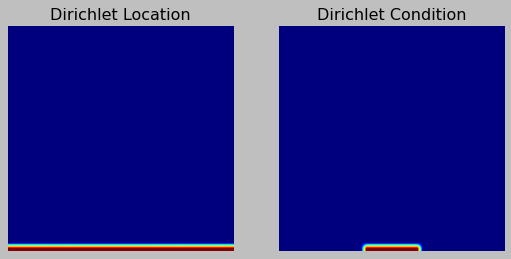

In [11]:
plt.subplot(121)
plt.title('Dirichlet Location')
plt.imshow(prob.dirichlet_loc[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Dirichlet Condition')
plt.imshow(prob.dirichlet_bcs[::-1])
plt.axis('off')
plt.show()

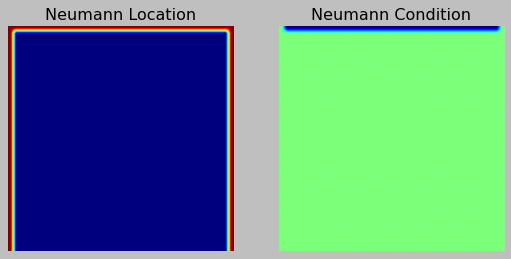

In [12]:
plt.subplot(121)
plt.title('Neumann Location')
plt.imshow((prob.neumann_loc[0]+prob.neumann_loc[1])[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Neumann Condition')
plt.imshow((prob.neumann_bcs[0]+prob.neumann_bcs[1][::-1]),vmax=1,vmin=-1)
plt.axis('off')
plt.show()

In [13]:
prob.iterate(10)

0: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [02:44<00:00, 16.44s/it]


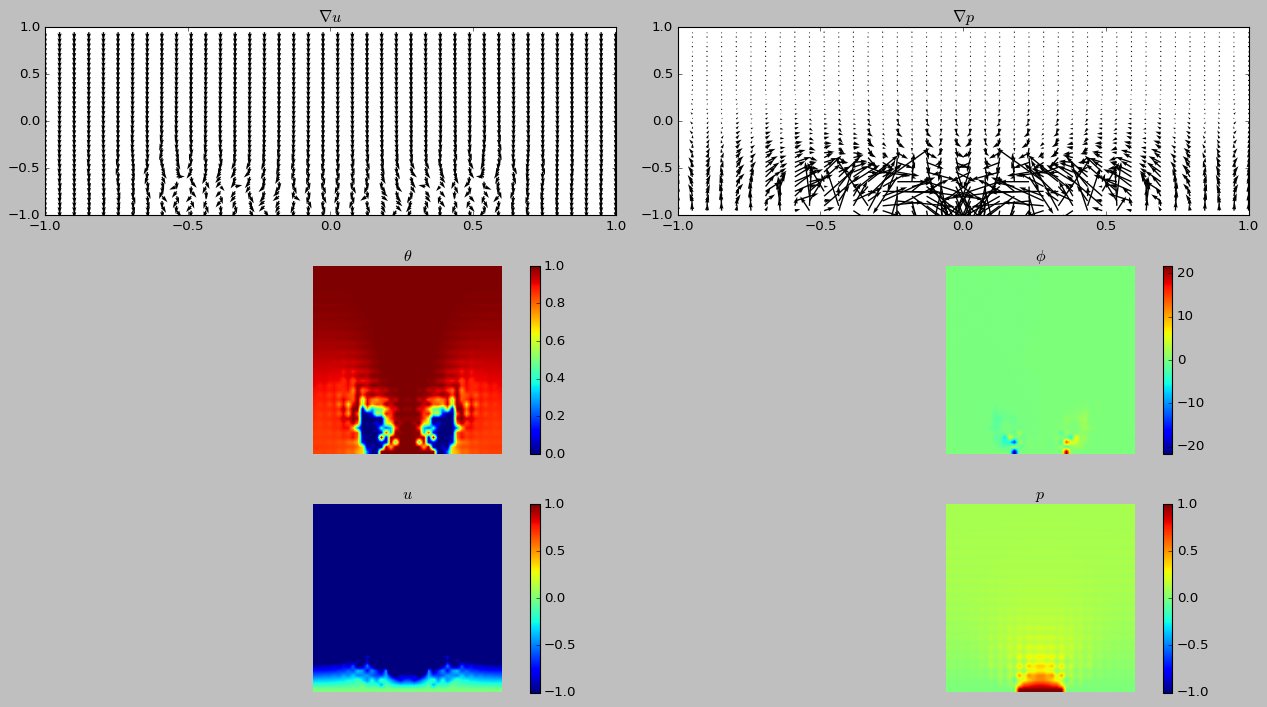

In [14]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
Du = np.divide(prob.Du,np.fmax(1,np.linalg.norm(prob.Du, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],Du[0][1:-1],Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
Dp = np.divide(prob.Dp,np.fmax(1,np.linalg.norm(prob.Dp, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],Dp[0][1:-1],Dp[1][1:-1])
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],cmap='grey',vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()

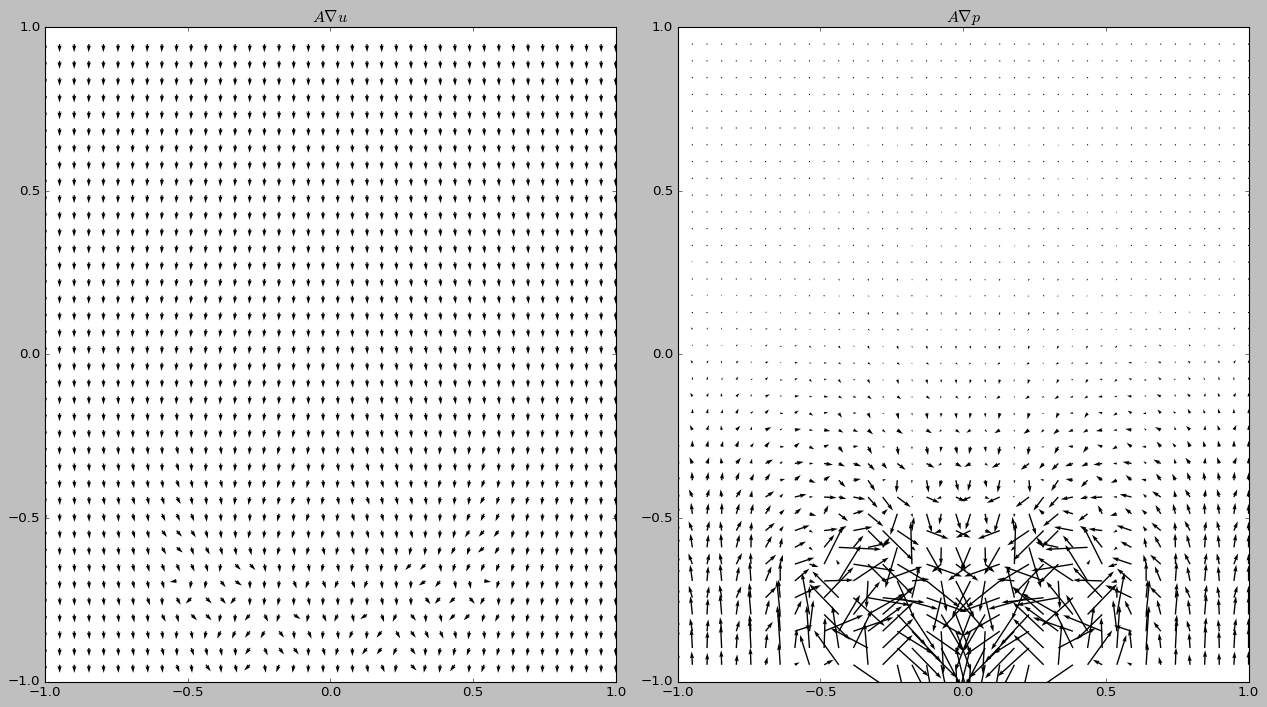

In [15]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(121)
ADu = np.divide(prob.ADu,np.fmax(.1,np.linalg.norm(prob.ADu, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],ADu[0][1:-1],ADu[1][1:-1])
plt.title('$A\\nabla u$')
plt.subplot(122)
plt.title('$A\\nabla p$')
ADp = np.divide(prob.ADp,np.fmax(.1, np.linalg.norm(prob.ADp, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],ADp[0][1:-1],ADp[1][1:-1])
plt.show()

In [16]:
print(prob.ADu[0][:,-1])
print(prob.ADu[0][:,0])
print(prob.ADu[1][-1,:])
print(prob.ADp[1][-1,:])

[-2.76678316e-15 -3.94138545e-17  2.94354798e-16 -8.43097839e-18
  2.49793640e-16  8.27692021e-16  5.33541821e-16 -1.44112919e-16
 -1.37584986e-15 -3.26154632e-16 -1.66322944e-15 -2.53402577e-15
 -4.30706829e-16 -3.11602330e-16  9.96347188e-16 -7.38583887e-17
  7.17910230e-16 -6.83813515e-17 -1.64739615e-17 -2.14996158e-15
  1.07492642e-15 -8.72007713e-16  3.26146282e-15 -4.61385616e-15
  7.05263830e-15 -5.15778853e-15 -2.44482992e-15  3.71614456e-15
  1.01569516e-14  6.93739681e-15  6.38297791e-17 -5.37792039e-15
  1.41026334e-16 -4.41336084e-17  6.03378494e-15  5.63514465e-15
 -2.10195266e-16 -5.68543435e-15 -1.14274563e-14  1.25983334e-24]
[ 5.40229862e-14 -4.96774095e-17 -1.06367985e-16 -2.98638474e-16
  4.14760676e-16 -5.42390187e-16  8.08037957e-16 -7.27109693e-16
 -4.39485138e-16 -1.42021924e-15 -1.35756448e-15  9.42802510e-16
 -4.60430202e-16  1.26375770e-16 -2.96698312e-16  1.82588321e-15
  2.02719018e-15 -3.69226696e-16  6.07124722e-16 -1.67863398e-15
 -2.23397006e-15 -3.1144

## Example 2

In [17]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [18]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-m//4:-1,0] = -np.ones(m//4-1)
neumann_bcs[1,-m//4:-1,-1] = -np.ones(m//4-1)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:-1,-1] = np.ones(n-1)
neumann_loc[0,:-1,0] = np.ones(n-1)
neumann_loc[1,-1,:] = np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':1, 'volume':.75,
         'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,
         'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,options)

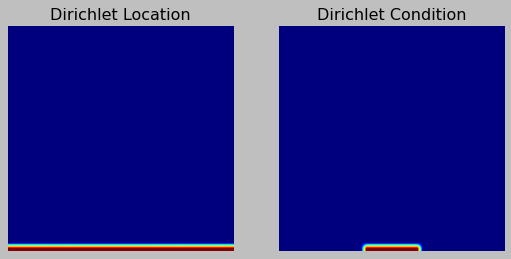

In [19]:
plt.subplot(121)
plt.title('Dirichlet Location')
plt.imshow(prob.dirichlet_loc[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Dirichlet Condition')
plt.imshow(prob.dirichlet_bcs[::-1])
plt.axis('off')
plt.show()

(-0.5, 39.5, 39.5, -0.5)

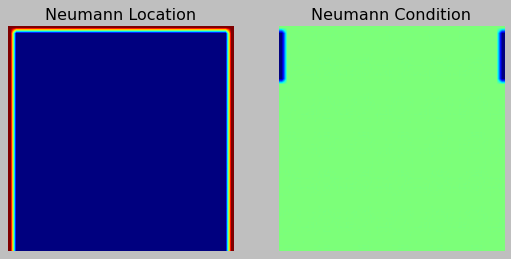

In [20]:
plt.subplot(121)
plt.title('Neumann Location')
plt.imshow((prob.neumann_loc[0]+prob.neumann_loc[1])[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Neumann Condition')
plt.imshow((prob.neumann_bcs[0]+prob.neumann_bcs[1][::-1]),vmax=1,vmin=-1)
plt.axis('off')

In [21]:
prob.iterate(10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Justin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
1:  40%|████████████████████████████████                                                | 4/10 [02:29<03:47, 37.99s/it]C:\Users\Justin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: xtol=0.000595 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
1: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [05:36<00:00, 31.24s/it]


C:\Users\Justin\Anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: overflow encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\Justin\Anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\Justin\Anaconda3\lib\site-packages\matplotlib\image.py:488: RuntimeWarning: overflow encountered in true_divide
  vrange /= ((a_max - a_min) / frac)
C:\Users\Justin\Anaconda3\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


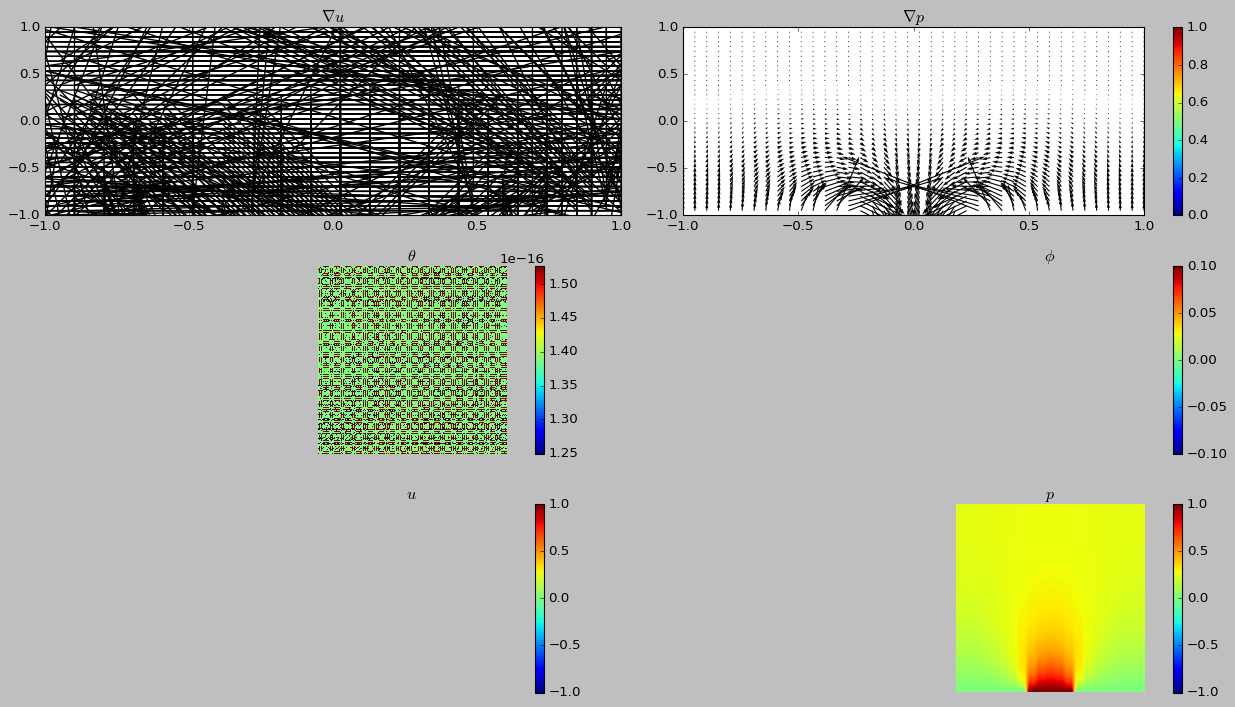

In [22]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Du[0][1:-1],prob.Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Dp[0][1:-1],prob.Dp[1][1:-1])
plt.colorbar()
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()